# Approximate the Schrödinger equation solution with Multi-Layer Perceptrons

MEHDI AYOUZ LGPM CENTRALESUPELEC
[mehdi.ayouz@centralesupelec.fr](mehdi.ayouz@centralesupelec.fr)

In this notebook, we use a neural network model (specifically, a multi-layer perceptron) to find the solutions of the Schrödinger equation in 1-dimension.

We first generate a set of potentials (which are given by a polynomial $V(x) = \sum_{i=0}^{k-1} \alpha_i x^i$) and solve the Schrödinger associated to that potential using numerical methods. This provides us with, among others, the wave functions and their energies.

We construct a dataset, which is composed of the potentials as features and wave functions as labels. After the standard splitting of the dataset into a training and evaluation subsets, we train the a neural network model such that the loss function, which we chose to be a mean square error 

$$\text{MSE}(\varphi,\hat \varphi) = \frac{1}{n} \sum_{i=0}^{n-1} (\varphi_i-\hat \varphi_i)^2,$$

between wave functions $\varphi$ associated to the potentials $V$ and the predictions $\hat \varphi$ is minimised for the predictions of the model given a 

$$ \hat \varphi = \text{MLP}(V) .$$

After the training, we evaluate the thus obtained model on the validation data, which we have put away for this exact occasion.

Moreover, the polynomial potentials

$$V(x) = \sum_{i=0}^{k-1} \alpha_i x^i,$$

are not the only class of the potentials that one can consider. There are potentials for which one can obtain the solutions of the Schrödinger equations using analytical methods. The most famous of them is the case of harmonic oscillator, which corresponds to the quadratic potential

$$V(x) = \frac{1}{2} m\omega^2 x^2 .$$

Moreover, the Schrödinger equation for the Morse potential

$$V(x) = D_e [(1-e^{-a(x-x_{e})})^{2}-1] ,$$

admits analytic solutions. Given that we know the exact wave functions for those potentials, we ask what is the performance of our multi-layer perceptron model which was trained on polynomial potentials. In particular, one can ask:

- will the performance of the machine learning model be good for the harmonic oscillator, given the form of its potential? Is the potential of the harmonic oscillator a subset of the polynomial potentials? How does it impact the prediction of the model?
- The Morse potential can be expanded into a following infinite series:
$$V(x) = 2 D_e \sum_{n=0}^\infty \frac{(-a)^n (x-x_e)^n}{n!} [2^{n-1} - 1] .$$
  When an infinite series can be approximated by a Taylor series expansion/finite power series? What are the necessary conditions for that? Would that be enough to achieve good predictions from the MLP model?

The Schrödinger equation uses a wave function $\psi:\mathbb{R}^d\to\mathbb{R}^m$ to characterize the quantum particle. The steady-state equation with constant energy $E$ reads:

$$-\frac{\boldsymbol{\Sigma}_m(\boldsymbol{x})}{2}\boldsymbol{\Delta\psi}(\boldsymbol{x})+\mathbb{V}(\boldsymbol{x})\boldsymbol{\psi}(\boldsymbol{x})=\mathbb{E}\boldsymbol{\psi}(\boldsymbol{x})$$

where $\boldsymbol{\Delta\psi}$ is the Laplacian operator, $\mathbb{V}(\boldsymbol{x})$ potential field and  $\boldsymbol{\Sigma}_m\in R^{d\times d}$ a positive definite matrix representing the inverse mass matrix of the particle. 

- Kinetic energy of the particle: $-\frac{\boldsymbol{\Sigma}_m(\boldsymbol{x})}{2}\boldsymbol{\Delta\psi}(\boldsymbol{x})$
- Potential energy of the particle $\mathbb{V}(\boldsymbol{x})\boldsymbol{\psi}(\boldsymbol{x})$

The left hand side of the steady-state Schrödinger equation is the application of an Hermitian operator $ \hat{\mathbb{H}}$ on $\boldsymbol{\psi}(\boldsymbol{x})$, i.e. $\hat{\mathbb{H}}\boldsymbol{\psi}=\mathbb{E}\boldsymbol{\psi}$.

Therefore, the Hermitian operator $\hat{\mathbb{H}}$ provides a complete set of real __eigenstates__ $\boldsymbol{\tilde\psi}_i(\boldsymbol{x})$ according to the following equations:
$$\hat{\mathbb{H}}  \boldsymbol{\tilde\psi}_i(\boldsymbol{x})=\mathbb{E}_i\boldsymbol{\tilde\psi}_i\qquad \int_{\mathbb{R}^d}\langle\boldsymbol{\tilde\psi}_i(\boldsymbol{x})\vert\boldsymbol{\tilde\psi}_j(\boldsymbol{x})\rangle d\boldsymbol{x}=\delta_{ij}$$

with $\mathbb{M}=\mathbb{I}$.

Each eigenstate is associated to an __eigen-energy__ $E_i$.

The standard equation (in physics) of a one-dimensional
harmonic oscillator is written as follows:

$$-\frac{1}{2m}\Delta \psi(x) +\frac{1}{2}mx^2\omega^2\psi(x)=E\psi(x)$$

with $\hat{H}(\cdot)=-\frac{1}{2m}\Delta(\cdot) +\frac{1}{2}mx^2\omega^2(\cdot)$

## 0. Preliminaries

### 0.1. Install `tensorflow` with `anaconda` and `pip`

- Create an `anaconda` environment

`conda create --name tf-py38 python=3.8`

- Activate `anaconda` environment

`conda activate tf-py38`

- Install `pip`

`conda install -c anaconda pip -y`

- Install `cudatoolkit`:

`conda install -c conda-forge cudatoolkit=11.8.0 -y`

- Install `nvidia-cudnn-cu11` and `tensorflow`

`python3 -m pip install nvidia-cudnn-cu11==8.6.0.163 tensorflow==2.12.*`

- Set environmental variables

`CUDNN_PATH=$(dirname $(python -c "import nvidia.cudnn;print(nvidia.cudnn.__file__)"))`

`export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:$CONDA_PREFIX/lib/:$CUDNN_PATH/lib`

- Verify install:
`python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"`

Import `python` modules:

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
from pylab import *  # for plot
from scipy.special import factorial
from scipy import linalg as LA
import scipy.sparse as sps
from scipy.linalg import eigh
from scipy.special import eval_hermite
from scipy.signal import argrelextrema
import matplotlib
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial
import tensorflow as tf
from tensorflow.keras import Model, layers

from sklearn.model_selection import train_test_split
# @title Energies as a function of N
#import plotly
#from plotly.graph_objs import graph_objs as go
#from plotly.subplots import make_subplots
#from plotly.offline import iplot

## 1. Numerical and analytical solutions of Schrödinger equation in 1-dimension

### 1.1. Computation of the energy of the system

We define a function which calculates the energy by integration:

In [2]:
# MKP: I have changed the name of the function to hamiltonian_expectation_value
def hamiltonian_expectation_value(φ,
                                  potential,
                                  xmin=-8,
                                  xmax=8,
                                  N=100,
                                  hbar=1,
                                  m=1):
    '''
    Function to calculate the empirical energy of a wavefunction
    Args:
      φ (np.array): Wavefunctions
      potential (np.array): potential V(x)
      xmin (int): minimum value of x
      xmax (int): maximum value of x
      N (int): number of grid points
      hbar (float): h bar
      m (float): mass
    Returns:
      E (np.array): empirical energies
    '''
    # Normalize φ just in case
    h = (xmax - xmin)/N

    def energy(φ, potential, h):
        '''
          Calculates the empirical energy for one wavefunction
          Args:
            φ (np.array): Wavefunctions
            potential (np.array): potential V(x)
            h (float): lattice size
          Returns:
            E (float): empirical energy 
        '''
        C = 1./np.sqrt(np.sum(φ*φ*h))
        φ = C*φ
        # We first calculate the second derivative of φ
        # We add 0 at the extrema.
        φr = np.concatenate((φ[1:], np.zeros(1)), axis=0)
        # It makes sense because φ(x)->0 at x->+-inf
        φl = np.concatenate((np.zeros(1), φ[:-1]), axis=0)

        deriv = (φr - 2.0*φ + φl)/(h*h)
        return np.sum((-hbar*hbar/(2*m)*φ*deriv + potential*(φ*φ))*h)

    E = np.array([energy(φ[i, :], potential[i, :], h)
                 for i in range(φ.shape[0])])
    return E

In [3]:
# MKP: A new function which calculates energy. It is more precise, but slightly slower than the previous one:
#      explicitly, it is still O(n) like the previous function, but it is ~2.5 slower in the limit of large N.
def get_energy(waves, Vs, x, mass=1., hbar=1.):
    '''
    Function to calculate the empirical energy of a wavefunction
    Args:
      waves (np.array): Wavefunctions
      Vs (np.array): potentials V(x)
      x (np.array): Values of x
      mass (float): mass
      hbar (float): h bar
    Returns:
      Es (np.array): energies
    '''
    
    N = x.shape[0]  # N==N
    delta_x = x[1]-x[0]

    T = np.zeros((N, N))
    L = delta_x*N

    for n in range(N):
        for m in range(N):
            if(n == m):
                T[n, m] = hbar**2*(-1)**(n-m)*np.pi**2/(mass*L**2)*(N**2+2)/6
            elif(n != m):
                T[n, m] = hbar**2*(-1)**(n-m)*np.pi**2/(mass*L**2) * \
                    1./(np.sin(np.pi*(n-m)/N))**2

    Es = np.zeros((waves.shape[0]))
    for i in range(Es.shape[0]):
        H = T + np.diag(Vs[i])
        Es[i] = (waves[i].T @ H @ waves[i]) / (waves[i].T @ waves[i])

    return Es

### 1.2. Solution of the Schödinger equation for polynomial potential

In this subsection, we define the class `eigen_state_potential` which describes the polynomial potentials

$$V(x) = \sum_{i=0}^{k-1} \alpha_i x^i,$$

as well as their associated wave function solutions $\varphi$ and their energies.

In [4]:
class eigen_state_potential:
    def __init__(self, alpha_min=None, alpha_max=None, N=None, xmin=None, xmax=None):
        '''
        Class to generate data (V(x) and φ(x) ground state) for potentials of the form
        V(x) = sum_i alpha_i x^i, using the plane wave basis
        Args:
            alpha_min: vector of length N, with the minimum value of the coefficients alpha
            alpha_max: vector of length N, with the maximum value of the coefficients alpha
            the values of alpha will be randomly distributed in [alpha_min, alpha_max]
        '''
        if len(alpha_min) != len(alpha_max):
            print("Error. Inconsisten shapes")
        self.alpha_min = np.array(alpha_min)
        self.alpha_max = np.array(alpha_max)
        self.N = N  # Length of plane wave basis
        self.k = len(alpha_min)  # Number of alphas for V(x)
        self.xmin = xmin  # xmin
        self.xmax = xmax  # xmax
        # print(self.alpha_min,self.alpha_max,self.N,self.k,self.x_min,self.x_max)

    def delta(self, n, m):
        """
        Define the Dirac's delta
        """
        if(n == m):
            delta = 1
        else:
            delta = 0
        return delta

    def find_eigen_state(self, alphas, n_state):
        '''
        Finds the eigen state of a potential V(x) = sum_i alpha_i x^i
        Args:
            alphas(np array): size k. Coefficients of the potential V(x)
            n_state (int): Number of excited state (default n_state=0, ground state)
        Returns:
            E_a (float): Energy of the ground state for potential V
            a (np.array): size N. Coefficients in the basis of the H.O potential
        '''
        # 0. Generate matrix of C_nm
        N = self.N  # N==N
        xmin = self.xmin  # xmin
        xmax = self.xmax  # xmax

        T = np.zeros((N, N))
        delta_x = (xmax-xmin)/N
        L = delta_x*N
        mu = 1.
        # 1. Build matrix T using the plane wave basis

        for n in range(N):
            for m in range(N):
                if(n == m):
                    T[n, m] = (-1)**(n-m)*np.pi**2/(mu*L**2)*(N**2+2)/6
                elif(n != m):
                    T[n, m] = (-1)**(n-m)*np.pi**2/(mu*L**2) * \
                        1./(np.sin(np.pi*(n-m)/N))**2

        # 2. Build matrix V

        V = np.zeros((N, N))
        k = self.k  # k
        for n in range(N):
            x = xmin+n*delta_x
            # V[n,n]=0.5*x**2
            for i in range(k):
                V[n, n] += alphas[i]*x**i

        # 3. Build matrix H
        H = np.zeros((N, N))
        veps = np.zeros((N, N))
        vaps = np.zeros(N)
        a = np.zeros((N, n_state+1))
        E_a = np.zeros(n_state+1)
        for n in range(N):
            for m in range(N):
                H[n, m] = T[n, m] + V[n, m]*self.delta(n, m)

        # 4. Diagonalize matrix H
        vaps, veps = eigh(H)

        # 5. Set bound wave functions to be real and normalize them
        for n in range(N):
            norm = np.dot(veps[:, n], veps[:, n])
            macloc = np.argmax(abs(veps[:, n]))
            veps[:, n] = veps[:, n]*abs(veps[macloc, n])/veps[macloc, n]
            veps[:, n] = veps[:, n]/np.sqrt(delta_x*norm)

        # 6. We choose the vector with n_state-th lowest energy
        # as an approximation of the n_state state
        a = veps[:, n_state]  # Final value of eigenvalues for state n_state
        E_a = vaps[n_state]  # Value of the energy
        return E_a, a

    def generate_data(self, n_samples, alpha=np.array([None]), n_state=None, display=100):
        '''
        Generates samples of potentials  with random coefficients and finds the n_state excited state for them
        Args:
            n_samples (int): Number of samples of potentials (alphas)
            alpha (np.array): Values of alpha. If you want to generate them randomly, don't provide anything
            n_state (int): Number of excited state (default n_state=0, ground state)
            display (int): Display step
        Returns:
            E (np.array): size n_samples. Ground energy for each V
            a (np.array): size n_samples x N. Coefficients in the H.O basis for each V
            alpha (np.array): size n_samples x k. Coefficients of the potentials V(x)
        '''
        data = np.zeros((n_samples, self.N))

        # Generate random value of alphas
        if (alpha == None).any():
            print("Random alphas")
            # Values between 0 and 1
            r_alpha = np.random.random((n_samples, self.k))
            alpha = r_alpha*(self.alpha_max - self.alpha_min) + \
                self.alpha_min  # random alpha

        # Prepare vectors of energies and coefficients
        E = np.zeros(n_samples)
        a = np.zeros((n_samples, self.N))
        # Find ground state for each sample
        for i in range(n_samples):
            E_new, a_new = self.find_eigen_state(alpha[i, :], n_state)
            if i % display == 0:
                print("\rGenerating data: {}/{}".format(i, n_samples), end='')
            E[i] = E_new
            a[i, :] = a_new
        return E, a, alpha

    def evaluate_potential(self, xmin, xmax, N, alpha):
        '''
        Given the coeefficients alphas, it evaluates the potential in V(x)
        Args:
            xmin(float): minimum value of x
            xmax (float): maximum value of x
            N (int): Number of points between xmin and xmax
            alpha (np.array): size N x k. Matrix of coefficients of V(x) (each row a different potential)
        Returns:
            V(np.array): size n_samples x N. V(x) for every sample
            x(np.array): size N. Values of x
        '''
        x = np.arange(xmin, xmax, (xmax - xmin)/N)
        n_samples, k = alpha.shape
        V = np.zeros((n_samples, N))
        # Matrix of powers of x: x^0, x^1, x^2, ..., x^N (in every row)
        x_mat = (x**np.arange(k)[:, None])
        V = np.zeros((n_samples, N))  # V(x) in each row different alpha
        for i in range(n_samples):
            for j in range(N):
                V[i, j] = np.dot(alpha[i, :], x_mat[:, j])

        return V, x

    def final_wavefunction(self, xmin, xmax, N, a):
        '''
        Returns the final wavefunctions psi(x) = sum_i alpha_i φ_i(x) for each alpha.
        Args:
            xmin(float): minimum value of x
            xmax (float): maximum value of x
            N (int): Number of points between xmin and xmax
            a (np.array): size n_samples x N. Coefficients in the H.O basis for each V
        Returns:
            waves(np.array): size n_samples x N. psi(x) for each value of V (given by alpha)
        '''
        x = np.arange(xmin, xmax, (xmax - xmin)/N)
        n_samples, _ = a.shape
        # Construct matrix of φ_n
        waves = np.zeros((n_samples, N))
        φs = np.zeros((n_samples, N))
        for i in range(n_samples):
            for j in range(N):
                waves[i, j] = a[i, j]
                φs[i, j] = waves[i, j]
                # convention: To choose the phase we make the maximums be first
            w = waves[i, :]
            maxi = argrelextrema(w, np.greater)[0]
            mini = argrelextrema(w, np.less)[0]
            idx2 = np.abs(w[maxi]) > 5e-2
            maxi = maxi[idx2]
            idx2 = np.abs(w[mini]) > 5e-2
            mini = mini[idx2]
            if len(maxi) == 0 and len(mini) > 0:
                waves[i, :] = -waves[i, :]
            elif len(mini) > 0 and len(maxi) > 0 and mini[0] < maxi[0]:
                waves[i, :] = -waves[i, :]
        return waves, x, φs

### 1.3. Definition of the Harmonic Oscillator and its analytical solution

In this subsection, we define the class `Harmonic_Oscillator` which describes the harmonic oscillator potential

$$V(x) = \frac{1}{2} m\omega^2 x^2 .$$

With this potential, the class also provides analytical wave function solutions $\varphi$ given in terms of Hermite polynomials, as well as their associated energies.

In [5]:
class Harmonic_Oscillator:
    '''
    Class to generate potential and wavefunctions of an harmonic oscillator.
    Attributes:
    omega_min (float): Minimum value of omega
    omega_max (float): Maximum value of omega
    x0_min (float): Minimum value of x0
    x0_max (float): Maximum value of x0
    hbar (float): h bar
    m (float): mass
    N (int): number of points of the grid
    omega (np.array): values of omega
    x0 (np.array): values of x0
    '''

    def __init__(self, omega_min=0.001, omega_max=1, x0_min=-0.5, x0_max=0.5,
                 hbar=1, m=1, x_range=0.8, N=100):
        self.omega_min = omega_min  # omega ~ U(omega_min, omega_max)
        self.omega_max = omega_max
        self.x0_min = x0_min
        self.x0_max = x0_max
        self.hbar = hbar
        self.m = m
        self.find_xrange(x_range)  # x in [-3 smax, 3smax]
        self.N = N  # Number of points of the grid
        self.omega = None
        self.x0 = None

    def find_xrange(self, x_range):
        '''
        Find range of x values x \in [-x_range * sigma_max, + x_range * sigma_max]
        Args:
        x_range (float)
        '''
        smax = np.sqrt(self.hbar/(self.m*self.omega_min))  # Find sigma_max
        self.xmin = -x_range*smax
        self.xmax = x_range*smax

    def generate_omega(self, N):
        '''
        Generates new values of omega
        Args:
        N (int): number of samples
        '''
        if N == None:
            N = 100
        self.omega = np.random.uniform(
            self.omega_min, self.omega_max, N).reshape(-1, 1)
        self.x0 = np.random.uniform(self.x0_min, self.x0_max, N).reshape(-1, 1)

    def generate_data(self, N=None, n=None, new_omega=True):
        '''
        Generates N random data points from the energetic level n
        Args:
        N (int): number of samples
        n (int): energetic level
        new_omega (boolean): if True, new values of omega are generated
        Returns:
        φ_n (np.array): HO wavefunctions
        x (np.array): grid
        omega (np.array): omega values for each sample
        x0 (np.array): values of x0 for each sample
        potential (np.array): V(x)
        '''
        if new_omega or self.omega.any() == None or self.x0.any() == None:
            self.generate_omega(N)

        x = np.arange(self.xmin, self.xmax, (self.xmax - self.xmin)/self.N)
        sigma_inv = np.sqrt(self.m*self.omega/self.hbar).reshape(-1, 1)
        ones = np.repeat(1, N)
        x_mat = np.tensordot(x, ones, axes=0).T
        # It is a matrix of dim (num_omega x num_x_points),
        all_x = (x_mat - self.x0)*sigma_inv
        # where each row has the values of x times sqrt(m*omega/hbar. In each row we change the value of omega
        herm = eval_hermite(n, all_x)  # H_n(x/sigma)
        exp = np.exp(- all_x**2/2)  # Exponential term

        φ_n = exp*herm

        h = (self.xmax - self.xmin)/self.N
        # 1/np.sqrt(2**n * math.factorial(int(n))) * np.sqrt(sigma_inv)# Normalization constant
        C = 1./np.sqrt(np.sum(φ_n*φ_n*h, axis=1))
        C = C.reshape(-1, 1)
        φ_n = C*φ_n  # exp*herm

        potential = (x_mat-self.x0)**2 * 1/2*self.m*self.omega**2

        return φ_n, x, self.omega, self.x0, potential

    def get_energy(self, n, omega=np.array([None])):
        '''
        Get theoretical energy
        Args:
        n (int): energetic level
        omega (np.array): values of omega
        Returns:
        E (np.array): energies
        '''
        if omega.any() == None:
            omega = self.omega
        E = self.hbar*omega*(n+1/2)
        return E.flatten()

### 1.4. Definition of the the Morse potential and the associated analytical solution

In this subsection, we define the class `Morse` which describes the Morse potential

$$V(x) = D_e [(1-e^{-a(x-x_{e})})^{2}-1] .$$

With this potential, the class also provides analytical wave function solutions $\varphi$ given in terms of Laguerre polynomials, as well as their associated energies.

In [6]:
class Morse:
    '''
    Class to generate potentials and wavefunctions of decoupled Morse potentials.
    Attributes:
    a_min (float): minimum value of Morse parameter a
    a_max (float): maximum value of Morse parameter a
    m (float): Mass
    xe_min (float): minimum value of Morse parameter xe
    xe_max (float): maximum value of Morse parameter xe
    hbar (float): h bar
    De_min (float): minimum value of Morse parameter De
    De_max (float): maximum value of Morse parameter De
    xmin (int): minimum value of x
    xmax (int): maximum value of x
    N (int): number of points of the domain
    a (np.array): Values of Morse parameters a
    xe (np.array): Values of Morse parameters xe
    De (np.array): Values of Morse parameters De
    '''

    def __init__(self, a_min=0.05, a_max=0.1, hbar=1, De_min=0.1, De_max=0.5, xe_min=-5,
                 xe_max=5, m=1, x_min=-30, x_max=30, N=100):
        self.a_min = a_min  # a ~ U(a_min, a_max)
        self.a_max = a_max
        self.m = m
        self.xe_min = xe_min
        self.xe_max = xe_max
        self.hbar = hbar
        self.De_min = De_min
        self.De_max = De_max
        self.xmin = x_min
        self.xmax = x_max
        self.N = N  # Number of points of the grid
        self.a = None
        self.xe = None
        self.De = None

    def generate_a(self, N):
        '''
        Generate Morse parameters a, xe, De
        Args:
          N (int): number of samples
        '''
        if N == None:
            N = 100
        self.a = np.random.uniform(self.a_min, self.a_max, N).reshape(-1, 1)
        self.xe = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1, 1)
        self.De = np.random.uniform(self.De_min, self.De_max, N).reshape(-1, 1)

    def generate_data(self, N=None, n=None, new_a=True):
        '''
        Generates N random data points from the energetic level n
        Args:
          N (int): number of samples
          n (int)_ energetic level
          new_a (boolean): if True, new parameters are generated
        Returns:
          phi (np.array): Wavefunctions
          x (np.array): x grid
          a (np.array): Values of a
          De (np.array): Values of De
          xe (np.array): Values of xe
          potential (np.array): V(x)
        '''
        if new_a or self.a.any() == None or self.xe.any() == None or self.De.any() == None:
            self.generate_a(N)

        x = np.arange(self.xmin, self.xmax, (self.xmax -
                      self.xmin)/self.N)  # Grid of x values
        lamb = np.sqrt(2*self.m*self.De)/(self.a*self.hbar)
        lamb = lamb.reshape(-1, 1)
        ones = np.repeat(1, N)
        x_mat = np.tensordot(x, ones, axes=0).T

        y = (x_mat-self.xe)*self.a
        z = 2*lamb*np.exp(-y)

        exp = np.exp(-1/2*z)  # exponential term
        pot = z**(lamb - n - 1/2)  # Potential term

        laguerre = eval_genlaguerre(n, 2*lamb - 2*n - 1, z)

        phi_n = pot*exp*laguerre

        h = (self.xmax - self.xmin)/self.N
        # np.sqrt(factorial(int(n)) * (2*lamb - 2*n - 1)/gamma(2*lamb - n)) # Normalization constant
        C = 1./np.sqrt(np.sum(phi_n*phi_n*h, axis=1))
        C = C.reshape(-1, 1)

        phi_n = C*phi_n

        potential = self.De*(np.exp(-2*y) - 2*np.exp(-y))

        return phi_n, x, self.a, self.De, self.xe, potential

    def get_energy(self, n, a=None, De=None):
        '''
        Returns analytical energy.
        Args:
          n (int): Energetic level
          a (np.array): Values of a
          De (np.array): Values of De
        Returns:
          E (np.array): energy for every sample
        '''
        if a.any() == None:
            a = self.a
        if De.any() == None:
            De = self.De
        lamb = np.sqrt(2*self.m*De)/(a*self.hbar)
        E = - self.hbar*self.hbar*a*a/(2*self.m)*(lamb - n-1/2)**2
        return E.flatten()

## 2. Training of the Multi-Layer Perceptron with `tensorflow`

### 2.1. Definition of the MLP model

In this subsection, we define a class containing the multi-layer perceptron neural network which we will use in the subsequent part of this notebook.

We use a neural network composed of 5 layers, 4 of which are fully connected hidden layers, and the remaining one is an output layer, with dropout layers in between. The dropout layers can be though as providing a regularisation procedure for the coefficients of the neural network by adding multiplicative noise to the training data. The input of the model is the potential of the Schrödinger equations and the output is a wave function (and possibly also its energy):

$$ \hat \varphi = \text{MLP}(V) .$$

In [7]:
# MKP: I modified the model in such a way that if one initialises the model with
#      the `with_energy` parameter being True, the dimension of the output is
#      augmented by 1 to account for the energy being the output alongside the
#      the wave functions.

class FC_Model(tf.keras.Model):
    '''
    Subclassed keras tf.keras.Model API. The input will be the potential V(x)
    and the output will be the wave function φ_n(x).
    Args:
      input_size (int): Number of x points
      with_energy (bool): Include energy alongside the wave function φ_n(x)
    Attributes:
      input_size (int): Number of x points
      fc1 (layer): First  fully cinnected layer with 512 filters and relu activation function
      dropout1 (layer): Dropout layer with dropout parameter of 0.2
      fc2 (layer): Second  fully cinnected layer with 256 filters and relu activation function
      dropout2 (layer): Dropout layer with dropout parameter of 0.2
      fc3 (layer): Third  fully cinnected layer with 256 filters and relu activation function
      dropout3 (layer): Dropout layer with dropout parameter of 0.2
      fc4 (layer): Fourth  fully cinnected layer with 128 filters and relu activation function
      dropout4 (layer): Dropout layer with dropout parameter of 0.2
      out (layer): Output layer predicting φ_n(x)
    '''

    def __init__(self,
                 name='fc_model', input_size=100,
                 n1=256, n2=256, n3=128, n4=128, drop=0.1,
                 with_energy=False, # MKP: I added the `with_energy` parameter
                 **kwargs):
        self.input_size = input_size
        self.with_energy = with_energy
        super(FC_Model, self).__init__(name=name, **kwargs)

        # Fully connected layer.

        self.fc1 = tf.keras.layers.Dense(n1,  activation='relu')
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout1 = tf.keras.layers.Dropout(rate=5*drop)

        # Fully connected layer.
        self.fc2 = tf.keras.layers.Dense(n2,  activation='relu')
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout2 = tf.keras.layers.Dropout(rate=3*drop)

        # Fully connected layer.
        self.fc3 = tf.keras.layers.Dense(n3, activation='relu')
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout3 = tf.keras.layers.Dropout(rate=4*drop)

        # Fully connected layer.
        self.fc4 = tf.keras.layers.Dense(n4, activation='relu')
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropout4 = tf.keras.layers.Dropout(rate=2*drop)

        # Output layer (fully connected with input_size neurons and linear activation function )
        self.out = tf.keras.layers.Dense(self.input_size+self.with_energy, activation='linear') # MKP: I have changed so that the output depends on `with_energy` parameter

    @tf.function
    def call(self, inputs, is_training=False):
        '''
        Forward pass of the fully connected model

        Args:
          inputs (tensor): X data to pass through the network (V(x))
          is_training (bool): If training, True, otherwise, False

        Returns:
          out (tensor): Output tensor containing the values of φ_n(x)
        '''
        x = tf.reshape(inputs, tf.constant([-1, self.input_size]))
        x = self.fc1(x)
        x = self.dropout1(x, training=is_training)
        x = self.fc2(x)
        x = self.dropout2(x, training=is_training)
        x = self.fc3(x)
        x = self.dropout3(x, training=is_training)
        x = self.fc4(x)
        x = self.dropout4(x, training=is_training)
        out = self.out(x)
        return out

### 2.2. Definition of the training function

In this subsection, we define a class with which we perform the training of the neural network.

We use the mean squared error (MSE) given by the following formula

$$\text{MSE}(\varphi,\hat \varphi) = \frac{1}{n} \sum_{i=0}^{n-1} (\varphi_i-\hat \varphi_i)^2,$$

as the loss function according to which the gradient descent training of the parameters of the model is performed.

In [8]:
class Training():
    '''
    Performs the training of the autoencoder model using mean absolute error loss

    Args:
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them

    Attributes: 
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    stopping_step (int): How many epochs we have waited so far without the validation loss decreasing
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them
    loss (function): Loss function to optimize. In this case, mean square error
    optimizer (tf.Optimizer): Adam optimizer for the learning steps
    ckpt (tf.Checkpoint): Checkpoint that stores weights and optimizer state
    manager (tf.CheckpointManager): Controls that not too many checkpoint files are stored 
    '''

    def __init__(self,
                 net,
                 learning_rate,
                 training_iters,
                 batch_size,
                 display_step,
                 early_stopping=50,
                 filepath=None,
                 restore=True,
                 loss=tf.keras.losses.MeanSquaredError(), # MKP: I have added the parameter allowing for a custom loss function
                 supress_logging=False):
        self.net = net
        self.learning_rate = learning_rate
        self.training_iters = training_iters
        self.batch_size = batch_size
        self.display_step = display_step
        self.stopping_step = 0
        self.loss = loss
        self.early_stopping = early_stopping
        self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.filepath = filepath
        self.supress_logging = supress_logging
        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, net=self.net)
        self.manager = tf.train.CheckpointManager(
            self.ckpt, directory=filepath, max_to_keep=3)
        if restore:
            self.ckpt.restore(self.manager.latest_checkpoint)
            if self.manager.latest_checkpoint:
                if not self.supress_logging:
                    print("Restored from {}".format(
                        self.manager.latest_checkpoint))
            else:
                if not self.supress_logging:
                    print("Initializing from scratch.")

    def loss_val(self, x_val, y_val):
        '''
        Computes the validation loss 
        Args:
        x_val(tensor): batch of validation sample
        y_val (tensor): labels for validation
        Returns:
         val_loss(tensor): validation loss
        '''
        pred_val = self.net(x_val, False)
        val_loss = self.loss(pred_val, y_val)
        return val_loss

    def early_stop(self, epoch, val_loss, stop):
        '''
        Assesses if we have to stop training
        Args:
         epoch (int): current epoch
         val_loss (tensor): current validation loss
         stop (bool): early stop parameter
        Returns:
         stop(bool): True if the models stops training, false if it continues training
         '''
        # Store best validation loss
        if epoch == 0:
            self.best_loss = val_loss
        else:
            if val_loss < self.best_loss:
                self.stopping_step = 0
                self.best_loss = val_loss
            else:
                # If the validation loss does not decrease, we increase the number of stopping steps
                self.stopping_step += 1
        # If such number reaches the maximum, we stop training
        if self.stopping_step == self.early_stopping:
            stop = True
            if not self.supress_logging:
                print('Early stopping was triggered, epoch =%f\n' % epoch)
        return stop

    # Optimization process.
    @tf.function()
    def run_optimization(self, x, y):
        '''
        Performs one step of the learning process. It calculates the loss function and
        appies backpropagation algorithm to update the weights.

        Args:
        x (tensor): Samples of training data used to train the model
        y (tensor): Labels for training data

        Returns:
        -
        '''
        # Wrap computation inside a GradientTape for automatic differentiation.
        with tf.GradientTape() as g:
            # Forward pass.
            pred = self.net(x)
            # Compute loss.
            loss = self.loss(pred, y)

        # Variables to update, i.e. trainable variables.
        trainable_variables = self.net.trainable_variables

        # Compute gradients.
        gradients = g.gradient(loss, trainable_variables)

        # Update W and b following gradients.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss

    # @tf.function
    def fit(self, X_train, y_train, X_test, y_test, save=True):
        '''
        Main fit function 

        Args:
          X_train (numpy array): Processed training data
          y_train (numpy array): Labels training data
          X_test (numpy array): Processed test data
          y_test (numpy array): Labels test data
          save (bool): If true, we save the weights at the end of the training
        Returns:
          -
        '''
        # Create train and test datasets
        # Use tf.data API to shuffle and batch data.
        train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_data = train_data.repeat().shuffle(
            5000).batch(self.batch_size).prefetch(1)

        test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
        test_data = test_data.shuffle(buffer_size=1024).batch(self.batch_size)

        loss_batch = []
        val_loss_batch = []

        stop = False
        epoch = 0
        # Run training for the given number of steps (and while not early stopping).
        while epoch < self.training_iters and stop == False:
            for step, (batch_x_train, batch_y_train) in enumerate(train_data.take(self.training_iters), 1):
                # Apply backpropagation algorithm
                loss = self.run_optimization(batch_x_train, batch_y_train)
                loss_batch.append(loss.numpy())

            # MKP: This block of 7 lines was indented once too many times, which made the calculation
            # of the validation loss wrong and therefore lead to early stopping
            for (test_x, test_y) in test_data:
                # Compute validation loss
                val_loss = self.loss_val(test_x, test_y)
                val_loss_batch.append(val_loss.numpy())

            stop = self.early_stop(epoch, val_loss, stop)
            epoch += 1

            # Display the result
            if epoch % self.display_step == 0:
                if not self.supress_logging:
                    print('Epoch: ', epoch, "Validation loss: ",
                          val_loss.numpy(), "Loss: ", loss.numpy())

        # Save the weights
        if save:
            save_path = self.manager.save()
            if not self.supress_logging:
                print("Saved checkpoint for step {}".format(save_path))

### 2.3. Generation of the dataset

In this subsection, we generate the dataset of polynomial potentials with their associated wave functions and energies.

We have to choose the following parameters in order to generate the dataset:

 - `xmin`, `xmax`: the parameters which determine the domain $\mathcal{D}=[x_{min}, x_{max}]$ of the potential $V(x), x\in D$;
 - `n_state`: determines the nth excited state of the Schrödinger equation, counting from the ground state (given by `n_state=0`) upwards with growing energy;
 - `N`: the amount of discretisation points into which we divide the domain $\mathcal{D}$ - higher $N$ corresponds to more precise numerical solution of the Schrödinger equation;
 - `n_samples`: the number of pairs (potential, wave function) (or possibly triples (potential, wave function, energy)) which constitute the dataset;
 - `alpha_min`, `alpha_max`: the arrays $\{ \alpha^\text{min}_i \}_{i=0}^{k-1}$ and $\{ \alpha^\text{max}_i \}_{i=0}^{k-1}$ which determine the lower and upper bounds
$$ \alpha^\text{min}_i \leq \alpha_i \leq \alpha^\text{max}_i, \qquad i=0,\ldots,k-1 ,$$
    for the parameters $\{ \alpha_i \}_{i=0}^{k-1}$ of the potential
$$V(x) = \sum_{i=0}^{k-1} \alpha_i x^i .$$
    The degree $k$ of the polynomial is inferred from the length of the arrays `alpha_min` and `alpha_max`.𝑥

In [9]:
# xmin = -8
# xmax = 8
# n_state = 1
# N = 200

# n_samples = 1000

# # We generate the values of alpha
# #alpha_min = np.array([-150,-10,0,-0.1,-0.25])/50
# #alpha_max = np.array([150,10,2,0.1,0.25])/50


# alpha_min = np.array([-0.2, -1, 0.1, 0, 0])
# alpha_max = np.array([0.2, 1, 0.75, 0, 0])


# k = alpha_min.shape[0]

# r_alpha = np.random.random((int(n_samples*0.8), k))  # Values between 0 and 1
# alpha1 = r_alpha*(alpha_max - alpha_min) + alpha_min  # random alpha

# alpha_min2 = np.array([-0.2, -1, 0.1, 0, 0])
# alpha_max2 = np.array([0.2, 1, 0.75, 0, 0])

# r_alpha = np.random.random((int(n_samples*0.2), k))  # Values between 0 and 1
# alpha2 = r_alpha*(alpha_max2 - alpha_min2) + alpha_min2  # random alpha
# alpha = np.concatenate((alpha1, alpha2))

# print(np.shape(alpha))
# # TODO generate the data from the eigen state potential
# data_gen = eigen_state_potential(alpha_min2, alpha_max2, N, xmin, xmax)


# # TODO Generate the energies, wavefunctions and potentials
# E, a, alpha = data_gen.generate_data(n_samples, alpha, n_state)
# waves, x, φs = data_gen.final_wavefunction(xmin, xmax, N, a)
# V, _ = data_gen.evaluate_potential(xmin, xmax, N, alpha)
# idx = -1

xmin = -8#@param 
xmax = 8#@param 
n_state=1#@param to be changed, the mass is 1 by default
N = 200#@param 
n_samples=499 #5000#@param 
#@markdown ---

# We generate the values of alpha
alpha_min = np.array([-150,-10,0.3,-0.1,0])/50
alpha_max = np.array([50,5,1.0,0.1,0.25])/50

k = alpha_min.shape[0]

r_alpha = np.random.random((int(n_samples*0.8), k)) # Values between 0 and 1
alpha1 = r_alpha*(alpha_max - alpha_min)+ alpha_min # random alpha

alpha_min2 = np.array([-10,-1,0.1,0,0])
alpha_max2 = np.array([5,1,1.0,0,0])

r_alpha = np.random.random((int(n_samples*0.2), k)) # Values between 0 and 1
alpha2 = r_alpha*(alpha_max2 - alpha_min2)+ alpha_min2 # random alpha
alpha = np.concatenate((alpha1, alpha2))

n_samples = alpha.shape[0]

data_gen = eigen_state_potential(alpha_min, alpha_max, N, xmin, xmax)

# Generate the energies, wavefunctions and potentials
E, a, alpha = data_gen.generate_data(n_samples, alpha,n_state)
waves, x,phis = data_gen.final_wavefunction( xmin, xmax, N, a)
V, _ = data_gen.evaluate_potential( xmin, xmax, N, alpha)
idx=-1
E_poly = E # MKP: I have added the line which preserves the energies so that they are not overwritten later on

Generating data: 0/498

Generating data: 400/498

#### 2.3.1. Plottin of the dataset

We want to visualise how do the polynomial potentials generated when constructing the dataset actually look like. We plot the potentials as well as their associated wave function solutions. 

It is apparent that the potentials are indeed given by the polynomial functions.

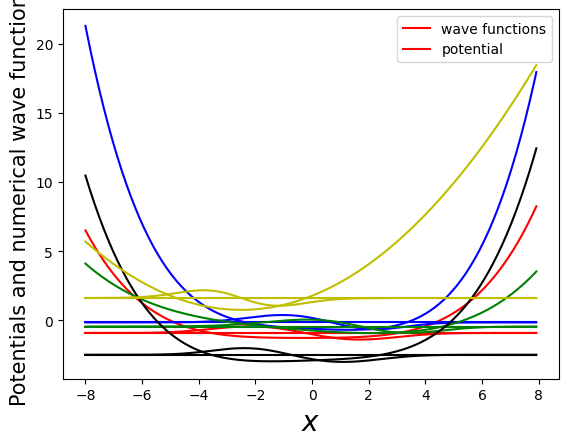

In [10]:
figure(1)
plot(x, waves[0, :]+E[0], '-r')
plot(x, V[0, :], '-r')
legend(["wave functions", "potential"])

tmp_E = np.ones(N, float)
tmp_E = tmp_E*E[0]
plot(x, tmp_E, '-r')
plot(x, waves[1, :]+E[1], '-b')
plot(x, V[1, :], '-b')

tmp_E = np.ones(N, float)
tmp_E = tmp_E*E[1]
plot(x, tmp_E, '-b')
plot(x, waves[2, :]+E[2], '-g')
plot(x, V[2, :], '-g')

tmp_E = np.ones(N, float)
tmp_E = tmp_E*E[2]
plot(x, tmp_E, '-g')
plot(x, waves[int(n_samples/2.), :]+E[int(n_samples/2.)], '-k')
plot(x, V[int(n_samples/2.), :], '-k')

tmp_E = np.ones(N, float)
tmp_E = tmp_E*E[int(n_samples/2.)]
plot(x, tmp_E, '-k')
plot(x, waves[n_samples-1, :]+E[n_samples-1], '-y')
plot(x, V[n_samples-1, :], '-y')

tmp_E = np.ones(N, float)
tmp_E = tmp_E*E[n_samples-1]
plot(x, tmp_E, '-y')
xlabel("$x$", size=20)
ylabel("Potentials and numerical wave functions", size=15)
show()

We also generate and plot a small test set containing quadratic potentials associated with the harmonic oscillator and their wave function solutions.

omega = [0.27483509]


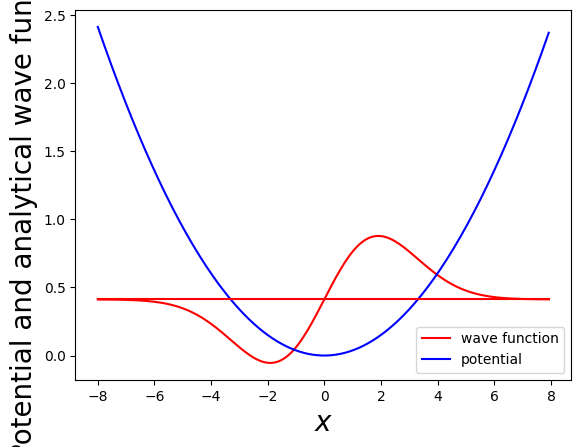

In [11]:
# TODO Generate H.O data
ho = Harmonic_Oscillator(N=N, omega_min=0.2, omega_max=1.0,
                         x0_min=-0.005, x0_max=0.005)  # TODO
ho.xmax = 8
ho.xmin = -8

phi0_HO, x, omega, x0, potential_HO = ho.generate_data(10, n_state)  # TODO

#   plot
figure(3)
tmp_E = np.ones(N, float)
tmp_E = tmp_E*omega[0]*(1./2.+n_state)
print("omega =", omega[0])
plot(x, phi0_HO[0, :]+tmp_E[0], '-r')
plot(x, potential_HO[0, :], '-b')
plot(x, tmp_E, '-r')
legend(["wave function", "potential"])
xlabel("$x$", size=20)
ylabel("Potential and analytical wave function", size=20)
show()

Finally, we generate and plot a test set of Morse potential and their associated wave function solutions. 

We see that while in the neighbourhood of the global minimum the Morse potential can be approximated in terms of polynomial functions, the function has an unmistakable exponential component further away from the global minimum.

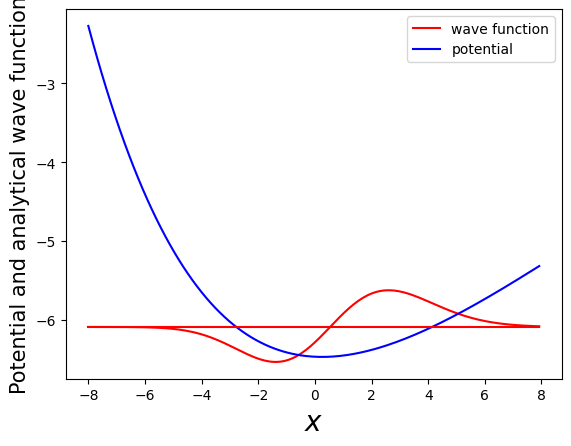

In [12]:
# TODO Generate Morse Data
morse = Morse(N=N,  x_min=-8, x_max=8, xe_min=-0.5,
              xe_max=0.5, De_max=7, De_min=3)  # TODO

phi0_morse, x, a, De, xe, potential_morse = morse.generate_data(
    10, n_state, True)  # TODO
#   plot
figure(4)
tmp_E = np.ones(N, float)
mu = 1
lamb = np.sqrt(2*mu*De[0])/a[0]
tmp_E = tmp_E*(- a[0]*a[0]/(2*mu)*(lamb - n_state-1/2)**2)
plot(x, phi0_morse[0, :]+tmp_E[0], '-r')
plot(x, potential_morse[0, :], '-b')
plot(x, tmp_E, '-r')
legend(["wave function", "potential"])
xlabel("$x$", size=20)
ylabel("Potential and analytical wave function", size=15)
show()

#### 2.3.2. Splitting the dataset into training and validation subsets

We split the dataset into training and validation subsets. We will use the training subset to train the machine learning model, while the validation subset will be used to evaluate the performance of the model.

In [13]:
# Split train and test
idx_train, idx_test, wave_train, wave_test = train_test_split(np.arange(V.shape[0]),
                                                              waves, test_size=0.33, random_state=123)
V_train = V[idx_train, :]
V_test = V[idx_test, :]

alpha_train = alpha[idx_train]
alpha_test = alpha[idx_test]

### 2.4. Simple Multi-Layer Perceptron 

#### 2.4.1. Set-up of the MLP hyper-parameters TODO

In this subsection, we define the hyper-parameters of the neural network model.

In [14]:
# # Parameters to train the neural network

# learning_rate = 0.02
# N = 200
# training_iters = 50
# batch_size = 48
# display_step = 10
# filepath = "./trained_models/random_potentials/1D/n0/tf_ckpts/"

learning_rate = 0.0005#@param {type:"number"}
N = 200 #200#@param{type:"integer"}
training_iters = 100 #@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 10#@param {type:"integer"}
filepath ="./trained_models2/random_potentials/1D/n0/tf_ckpts/" #@param {type:"string"}

#### 2.4.2. Training of the MLP

In [15]:
fc_model = FC_Model(input_size=N)

# Train the model from scratch
train = Training(fc_model, learning_rate, training_iters,
                 batch_size, display_step, early_stopping=20, filepath=filepath,
                 restore=False)
# Restore the model from previously trained weights
# train = Training(fc_model,learning_rate, training_iters, batch_size, display_step,
#                  filepath=filepath,early_stopping=100, restore=True)

train.fit(V_train, wave_train, V_test, wave_test)

2023-11-29 12:42:01.002796: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch:  10 Validation loss:  0.004781119147081048 Loss:  0.0008061443332042933
Epoch:  20 Validation loss:  0.0007656050674055454 Loss:  0.0002756351527469557
Epoch:  30 Validation loss:  0.0026854554195234687 Loss:  0.00017443062240486394
Epoch:  40 Validation loss:  0.0016030324712322669 Loss:  0.0001377536876485236
Epoch:  50 Validation loss:  0.0018411395518295182 Loss:  0.00015134328643749852
Epoch:  60 Validation loss:  0.00022815939794489556 Loss:  0.00010560200303431893
Epoch:  70 Validation loss:  0.00015504664451178318 Loss:  6.247106181443885e-05
Epoch:  80 Validation loss:  0.00107729243819407 Loss:  0.00025447989298480725
Epoch:  90 Validation loss:  0.0004717755996225777 Loss:  4.308009950857194e-05
Epoch:  100 Validation loss:  0.00014341721972756471 Loss:  2.4650278317193368e-05
Saved checkpoint for step ./trained_models2/random_potentials/1D/n0/tf_ckpts/ckpt-1


#### 2.4.3. Evaluation of the predictions on the validation dataset

In this subsection, we perform the evaluation of the performance of the multi-layer perceptron model.

First, we calculate the error of the prediction of the model on the validation subset of our dataset. We calculate the mean squared error

$$\text{MSE}(\varphi,\hat \varphi) = \frac{1}{n} \sum_{i=0}^{n-1} (\varphi_i-\hat \varphi_i)^2,$$

between the wave functions of the validation set and the predictions provided by the model. In addition, we use the energy formula to calculate the MSE between the energy of the target wave function and the energy of the predicted wave function.

We also plot, as an example, a target wave function with a corresponding predicted wave function to graphically evaluate how close to each other they are.

Finally, we plot the predicted energies against the target energies for all the wave functions of the validation dataset. Ideally, all the points should lie exactly on the diagonal of the graph, if the model truly makes the correct predictions. 

In [16]:
# MLP predictions
pred = fc_model(V_test)  # TODO
print("Test MSE for polynomial potential: %f" % train.loss(pred, wave_test))

# MKP: I have added the dependance on N to the parameters of the 2 function below:
E = get_energy(wave_test, V_test, x)
E_emp = get_energy(pred.numpy(), V_test, x)
print('MSE(E) for polynomial potential: ', np.mean((E - E_emp)**2))

Test MSE for polynomial potential: 0.000433
MSE(E) for polynomial potential:  0.3040398165627408


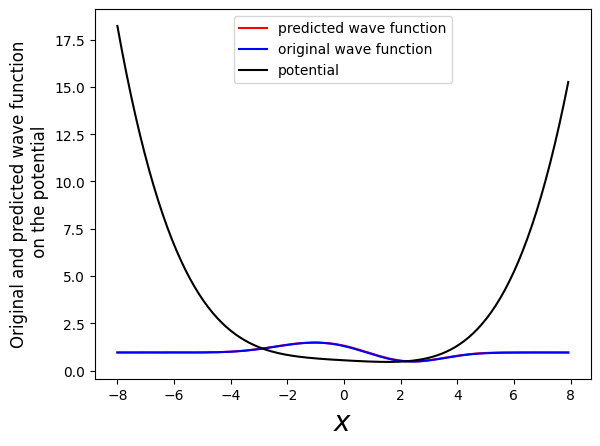

In [17]:
figure(5)
idx = 0  # 2
plot(x, pred.numpy()[idx, :]+E_emp[idx], '-r')
plot(x, wave_test[idx, :]+E[idx], '-b')  # real phi
plot(x, V_test[idx, :], '-k')  # Potential
legend(["predicted wave function", "original wave function", "potential"])
xlabel("$x$", size=20)
ylabel("Original and predicted wave function\n on the potential", size=12);

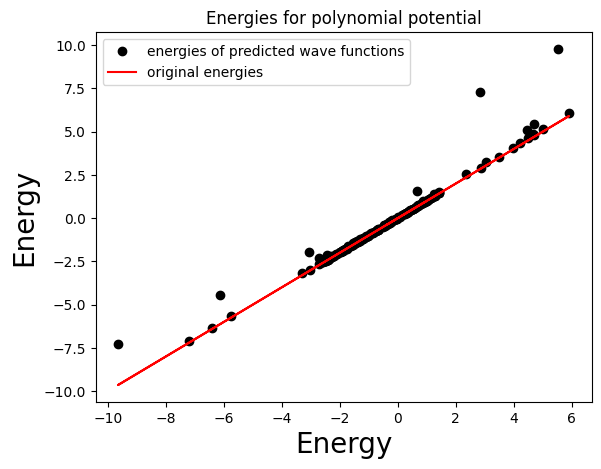

In [18]:
# plot Real and predicted mean energies
figure(6)
plot(E, E_emp, 'ok')  # empirical
plot(E, E, '-r')  # theorerical
legend(["energies of predicted wave functions", "original energies"])
xlabel("Energy", size=20)
ylabel("Energy", size=20)
title("Energies for polynomial potential");

We move to evaluate the performance of the neural net on the subset of harmonic oscillators. As before we calculate the mean squared error between the wave functions of the validation set and the predictions and use the energy formula to calculate the MSE between the energy of the target wave function and the energy of the predicted wave function.

We again illustrate a target wave function with a corresponding predicted wave function on a graph and we plot the predicted energies against the target energies for all the wave functions of the harmonic oscillator set.

In [19]:
# Test with HO
# Predict wavefunctions
pred_HO = fc_model(potential_HO)  # TODO
print("Test MSE for HO: %f" % train.loss(pred_HO, phi0_HO))

# MKP: I have added the dependance on N to the parameters of the 2 function below:
E = get_energy(phi0_HO, potential_HO, x)
E_emp = get_energy(pred_HO.numpy(), potential_HO, x)
print('MSE(E) for HO: ', np.mean((E - E_emp)**2))

Test MSE for HO: 0.251979
MSE(E) for HO:  0.012134743626978877


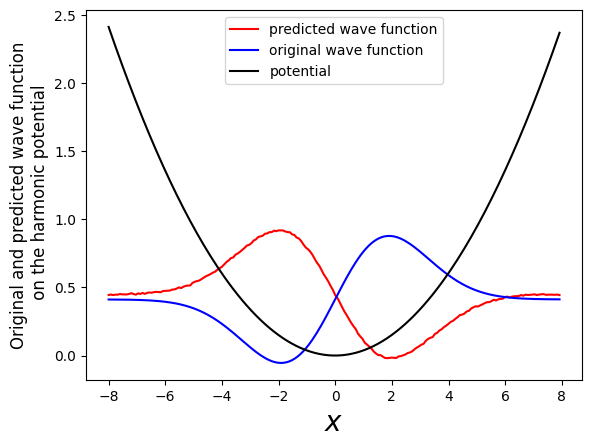

In [20]:
figure(7)
idx = 0  # 1
plot(x, pred_HO.numpy()[idx, :]+E_emp[idx], '-r')  # prediction phi
plot(x, phi0_HO[idx, :]+E[idx], '-b')  # real phi
plot(x, potential_HO[idx, :], '-k')  # Potential
legend(["predicted wave function", "original wave function", "potential"])
xlabel("$x$", size=20)
ylabel("Original and predicted wave function\n on the harmonic potential", size=12);

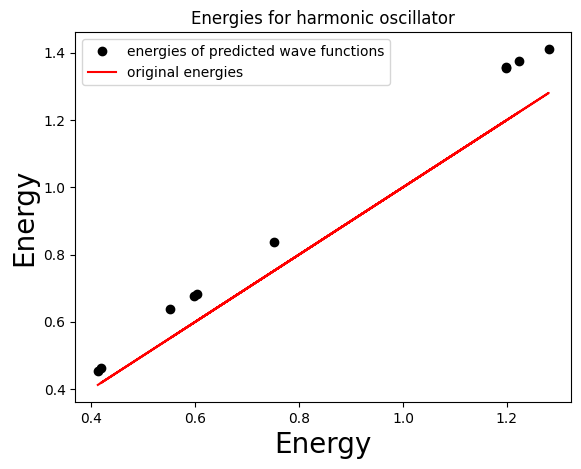

In [21]:
figure(8)
plot(E, E_emp, 'ok')  # empirical
plot(E, E, '-r')  # theorerical
legend(["energies of predicted wave functions", "original energies"])
xlabel("Energy", size=20)
ylabel("Energy", size=20)
title("Energies for harmonic oscillator");

To end this subsection, we test the neural net on the subset of Morse potential, defined in section 2.3.1. We calculate the mean squared error between the wave functions of the validation set and the predictions and use the energy formula to calculate the MSE between the energy of the target wave function and the energy of the predicted wave function.

We plot a target wave function with a corresponding predicted wave function and we plot the predicted energies against the target energies for all the wave functions of the Morse potential set.

In [22]:
# Test with Morse
# Predict wavefunctions
pred_morse = fc_model(potential_morse)  # TODO
print("Test MSE for Morse potential: %f" % train.loss(pred_morse, phi0_morse))

# MKP: I have added the dependance on N to the parameters of the 2 function below:
E = get_energy(phi0_morse, potential_morse, x)
E_emp = get_energy(pred_morse.numpy(), potential_morse, x)
print('MSE(E) for Morse potential: ', np.mean((E - E_emp)**2))

Test MSE for Morse potential: 0.230807
MSE(E) for Morse potential:  0.3028615348127213


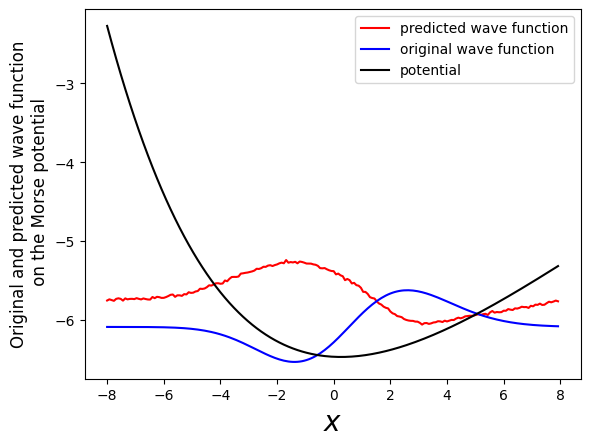

In [23]:
figure(9)
idx = 0  # 1
plot(x, pred_morse.numpy()[idx, :]+E_emp[idx], '-r')  # prediction phi
plot(x, phi0_morse[idx, :]+E[idx], '-b')  # real phi
plot(x, potential_morse[idx, :], '-k')  # Potential
legend(["predicted wave function", "original wave function", "potential"])
xlabel("$x$", size=20)
ylabel("Original and predicted wave function\n on the Morse potential", size=12);

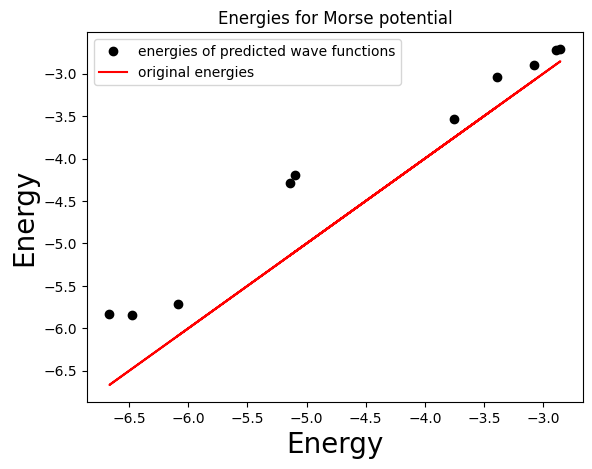

In [24]:
figure(10)
plot(E, E_emp, 'ok')  # empirical
plot(E, E, '-r')  # theorerical
legend(["energies of predicted wave functions", "original energies"])
xlabel("Energy", size=20)
ylabel("Energy", size=20)
title("Energies for Morse potential");